In [6]:
# coding: utf-8
import scipy.io as io
import numpy as np
import math
import torch
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

plt.gray();
import matplotlib.patheffects as pe
import seaborn as sb
from sklearn.manifold import TSNE 
from PIL import Image as img
from mpl_toolkits.mplot3d import Axes3D  # 进行3D图像绘制
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False # 显示中文

# from IPython.display import display

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
train_data=torchvision.datasets.CIFAR10(root='./',train=True,
                                        download=False,transform=transform)
test_data=torchvision.datasets.CIFAR10(root='./',train=False,
                                        download=False,transform=transform)
# train_loader=torch.utils.data.DataLoader(train_data,batch_size=50000,shuffle=True)
# test_loader=torch.utils.data.DataLoader(test_data,batch_size=10000,shuffle=True)
X=train_data.data
y=np.array(train_data.targets)[:, np.newaxis]
X_test=test_data.data
y_test=np.array(test_data.targets)[:, np.newaxis]
print(X.shape,y.shape,X_test.shape,y_test.shape)
print(np.unique(y))

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
[0 1 2 3 4 5 6 7 8 9]


<Figure size 576x288 with 0 Axes>

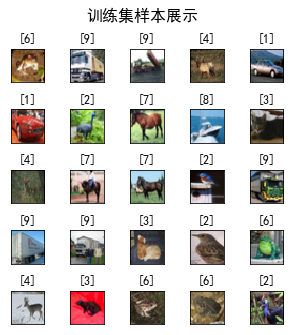

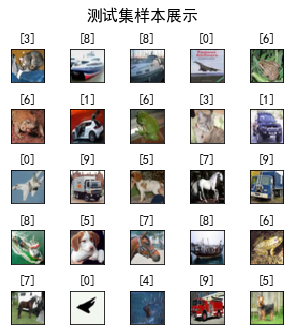

In [7]:
plt.rcParams['figure.figsize'] = (5,6) # 调整展示时的图片区域大小
# 随机选择一些图片进行展示，上方的数字是标签/类名
def plot_images(img, labels, r, c,name):
    randIndices=[np.random.randint(0,img.shape[0]) for i in range(r*c)]
    fig, axes = plt.subplots(r, c)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i],cmap="gray")
        else:
            ax.imshow(img[i,:,:,0],cmap="gray")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])
    plt.suptitle(name, fontsize=16, ha='center')
    plt.gcf().set_size_inches(450 / 100, 450 / 100)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=0.85, bottom=0, right=0.95, left=0.08, hspace=0.8, wspace=0.4)
    plt.margins(0, 0)

    
plot_images(X, y, 5, 5,"训练集样本展示")
plt.savefig('Pictures/train.png')
plot_images(X_test, y_test, 5, 5,"测试集样本展示")
plt.savefig('Pictures/test.png')

训练集中每个类的占比
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
测试集中每个类的占比
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


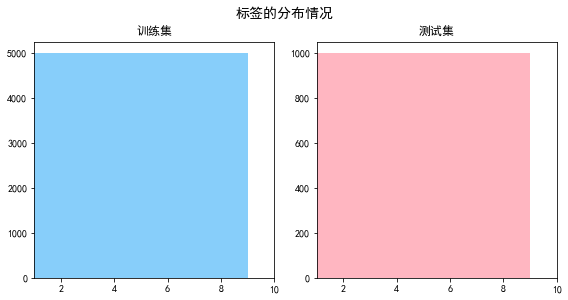

In [9]:
plt.rcParams['figure.figsize'] = (8,4) # 调整展示时的图片区域大小
# 查看类的分布情况
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('标签的分布情况', fontsize=14, fontweight='bold', y=1.03)

ax1.hist(y, color='#87CEFA',bins=10)
ax1.set_title("训练集")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='#FFB6C1', bins=10)
ax2.set_title("测试集")
# ax2.set_xlim(1, 10)
fig.tight_layout()

def print_distribution(y):
    d=[]
    for i in range(10):
        d.append(round(np.sum(y==i)/y.shape[0],3))
    print(d)

print('训练集中每个类的占比')
print_distribution(y)
print('测试集中每个类的占比')
print_distribution(y_test)

训练数字0 迭代第 1 次, loss= 4.00122511892501 acc_max= 0.6079 大w个数  0
第0个分类器训练完毕,  收敛到: 0.6655721917395216
数字0训练完毕
训练数字1 迭代第 1 次, loss= 4.180293210810732 acc_max= 0.60168 大w个数  0


In [7]:
num_label=10

def plot2D(x, colors,path_name):
    # 生成10种颜色出来
    palette = np.array(sb.color_palette("hls", num_label)) 
#     print(palette.shape)
    
    f = plt.figure(figsize=(32, 32))
    ax = plt.subplot(aspect='equal')
    # 将第一维和第二维作为xy坐标
    # lw: linewidth
    
    # set lable 
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)

    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, cmap="jet",marker="o", c=palette[colors.astype(np.int)])
    txts = []
    for i in range(num_label):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=32)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.title('Cifar10-tSNE',fontsize = 38, color = 'black',backgroundcolor='white')
    plt.savefig(path_name)
#     plt.axis('on')
#     plt.show()
    return f, ax, txts

def plot3D(x, colors):
    # 生成10种颜色出来
    palette = np.array(sb.color_palette("hls", num_label)) 
#     print(palette.shape)
    
    f = plt.figure(figsize=(32, 32))
#     ax = plt.subplot(aspect='equal')
    ax = Axes3D(f)
    # 将第一维和第二维作为xy坐标
    # lw: linewidth
    
    # set lable 
    ax.set_xlabel('X', fontsize=10)
    ax.set_ylabel('Y', fontsize=10)
    ax.set_zlabel('Z', fontsize=10)

    sc = ax.scatter(x[:,0], x[:,1],x[:,2], lw=0, s=40, cmap="jet",marker="o", c=palette[colors.astype(np.int32)])
    txts = []
    for i in range(num_label):
        # Position of each label.
        xtext, ytext,ztext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext,ztext, str(i), fontsize=32)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.title('Cifar10-tSNE',fontsize = 38, color = 'black',backgroundcolor='white')
    plt.savefig("Results/tSNE_original.png")
#     plt.axis('on')
#     plt.show()
    return f, ax, txts

torch.Size([200, 3072])
<class 'torch.Tensor'>
torch.Size([200])
(200, 3072)
<class 'numpy.ndarray'>
(200,)


D:\Anaconda3.5.3.1\lib\site-packages\sklearn\neighbors\base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


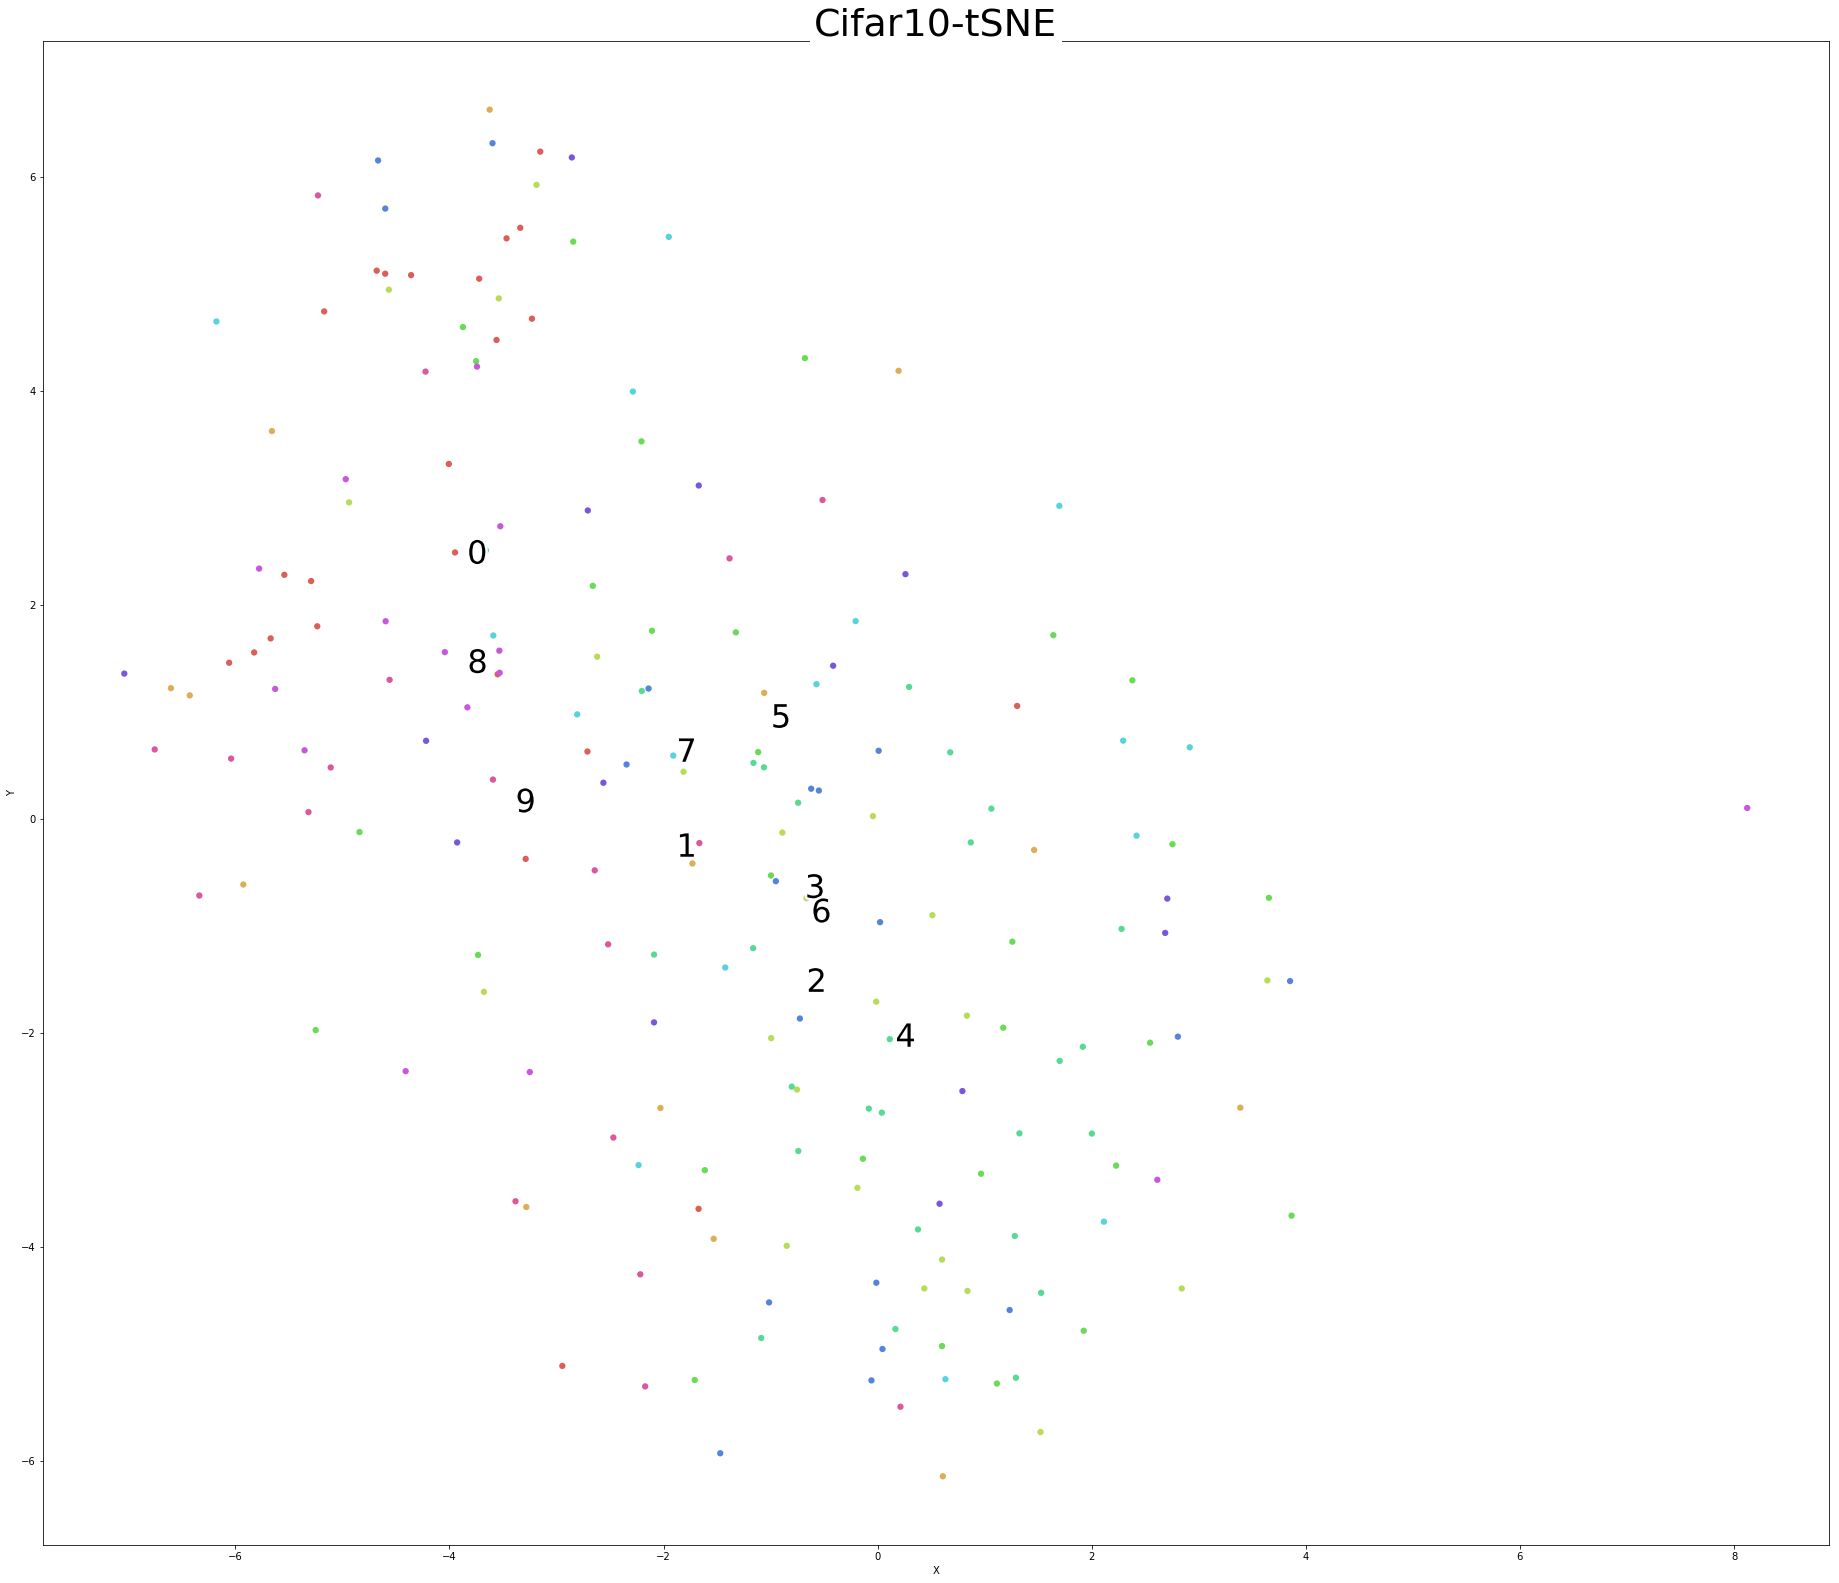

In [22]:
#  原始数据集
for batch in test_loader:
    X,Y=batch
    X=X.reshape(X.shape[0],-1)
    print(X.shape)
    print(type(Y))
    print(Y.shape)
#     print(X)
#     print(Y)
    
    X = np.vstack([X[(Y==i)] for i in range(num_label)]) 
    Y = np.hstack([Y[(Y==i)] for i in range(num_label)])
    
    tsne_output = TSNE(n_components=2,perplexity=50,n_iter=5000).fit_transform(X) 
    plot2D(tsne_output,Y)
    
#     tsne_output = TSNE(n_components=3,perplexity=10,n_iter=3000).fit_transform(X) 
#     plot3D(tsne_output,Y)
    break
# plot2D(tsne_output[:,0:2],Y)

target shape:  (50000, 10)
output shape:  (50000, 1)


(<Figure size 2304x2304 with 1 Axes>,
 [Text(-8.86486,-5.33908,'0'),
  Text(-58.4939,3.00168,'1'),
  Text(9.59618,-11.9021,'2'),
  Text(27.0094,11.2162,'3'),
  Text(27.8018,-17.8706,'4'),
  Text(37.8714,8.51446,'5'),
  Text(10.7308,22.0814,'6'),
  Text(54.3485,-16.9945,'7'),
  Text(-28.6376,9.29445,'8'),
  Text(-46.4753,-7.76666,'9')])

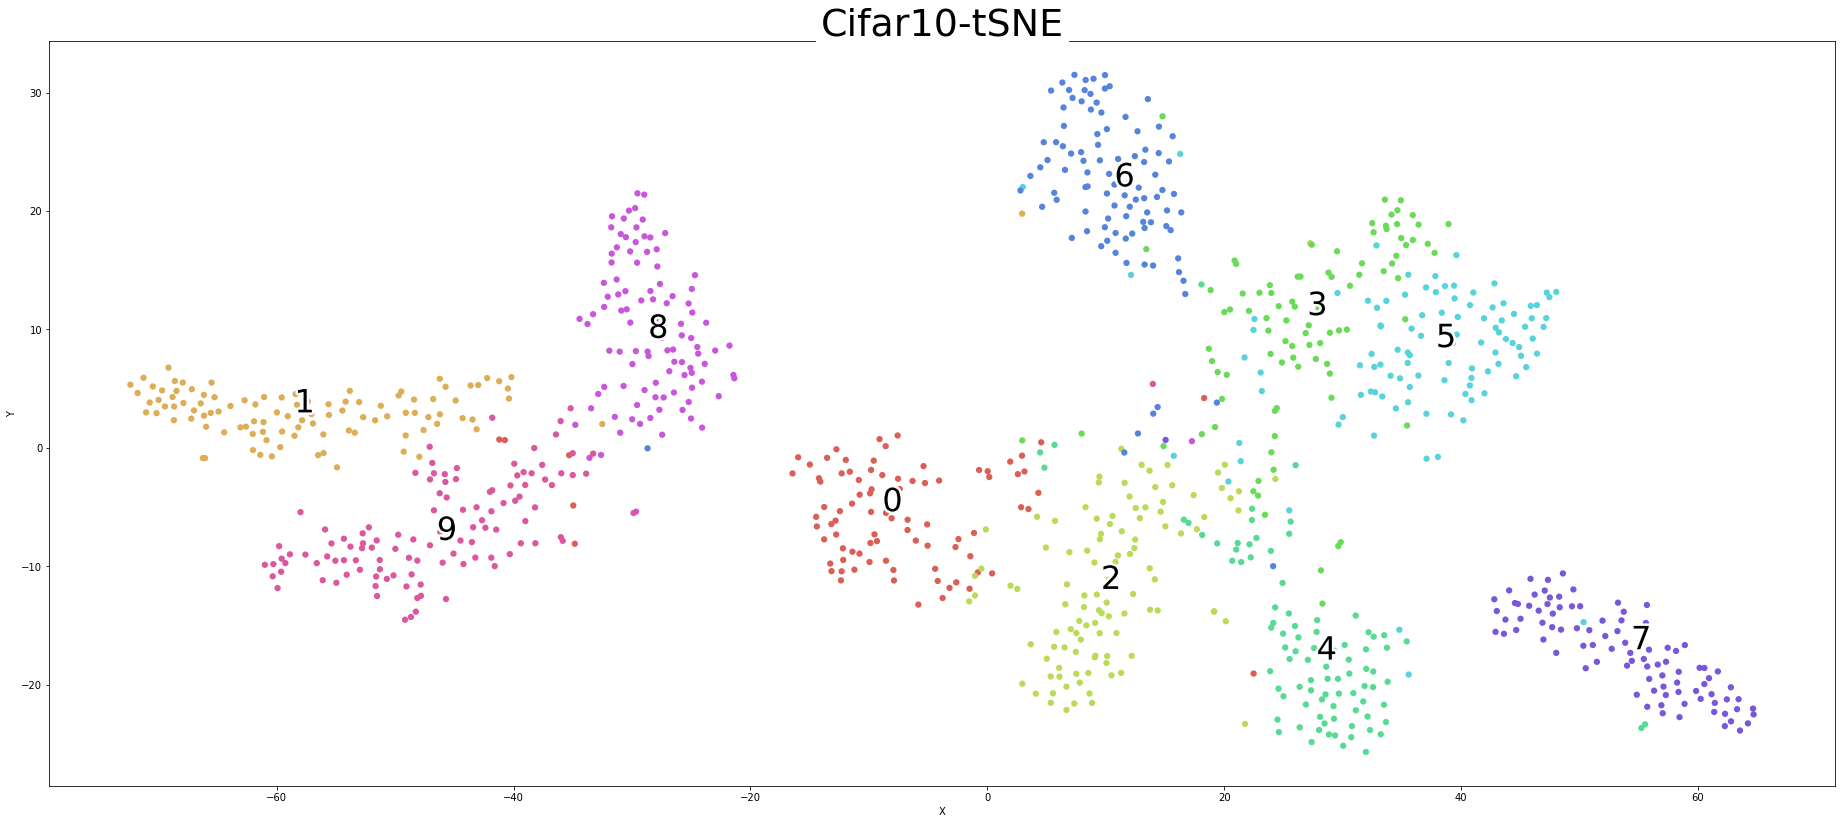

In [9]:
# 网络输出 训练集
X = np.load('Results/ZFNet_output.npy').astype(np.float64)
Y = np.load('Results/ZFNet_target.npy')
print('target shape: ', X.shape)
print('output shape: ', Y.shape)

# X=X.reshape(X.shape[0],-1)
# print(X.shape)
# print(type(Y))
X=X[0:1000,:]
Y=Y[0:1000,:]
# print('target shape: ', X.shape)
# print('output shape: ', Y.shape)
#     print(X)
#     print(Y)

X = np.vstack([X[(Y == i)[:, 0]] for i in range(num_label)])
Y = np.vstack([Y[(Y == i)[:, 0]] for i in range(num_label)])

tsne_output = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(X)
# print(tsne_output.shape)
# print(tsne_output)
plot2D(tsne_output, Y[:, 0], "Results/tSNE_ZFNet.png")

target shape:  (10000, 10)
output shape:  (10000, 1)


(<Figure size 2304x2304 with 1 Axes>,
 [Text(-14.5137,-8.40887,'0'),
  Text(-1.24525,-48.3873,'1'),
  Text(-6.70202,8.06088,'2'),
  Text(13.958,17.9254,'3'),
  Text(-11.2147,31.2117,'4'),
  Text(14.4005,29.0449,'5'),
  Text(15.6027,-0.688145,'6'),
  Text(-1.50848,46.4249,'7'),
  Text(-17.4152,-27.4121,'8'),
  Text(10.5419,-39.4011,'9')])

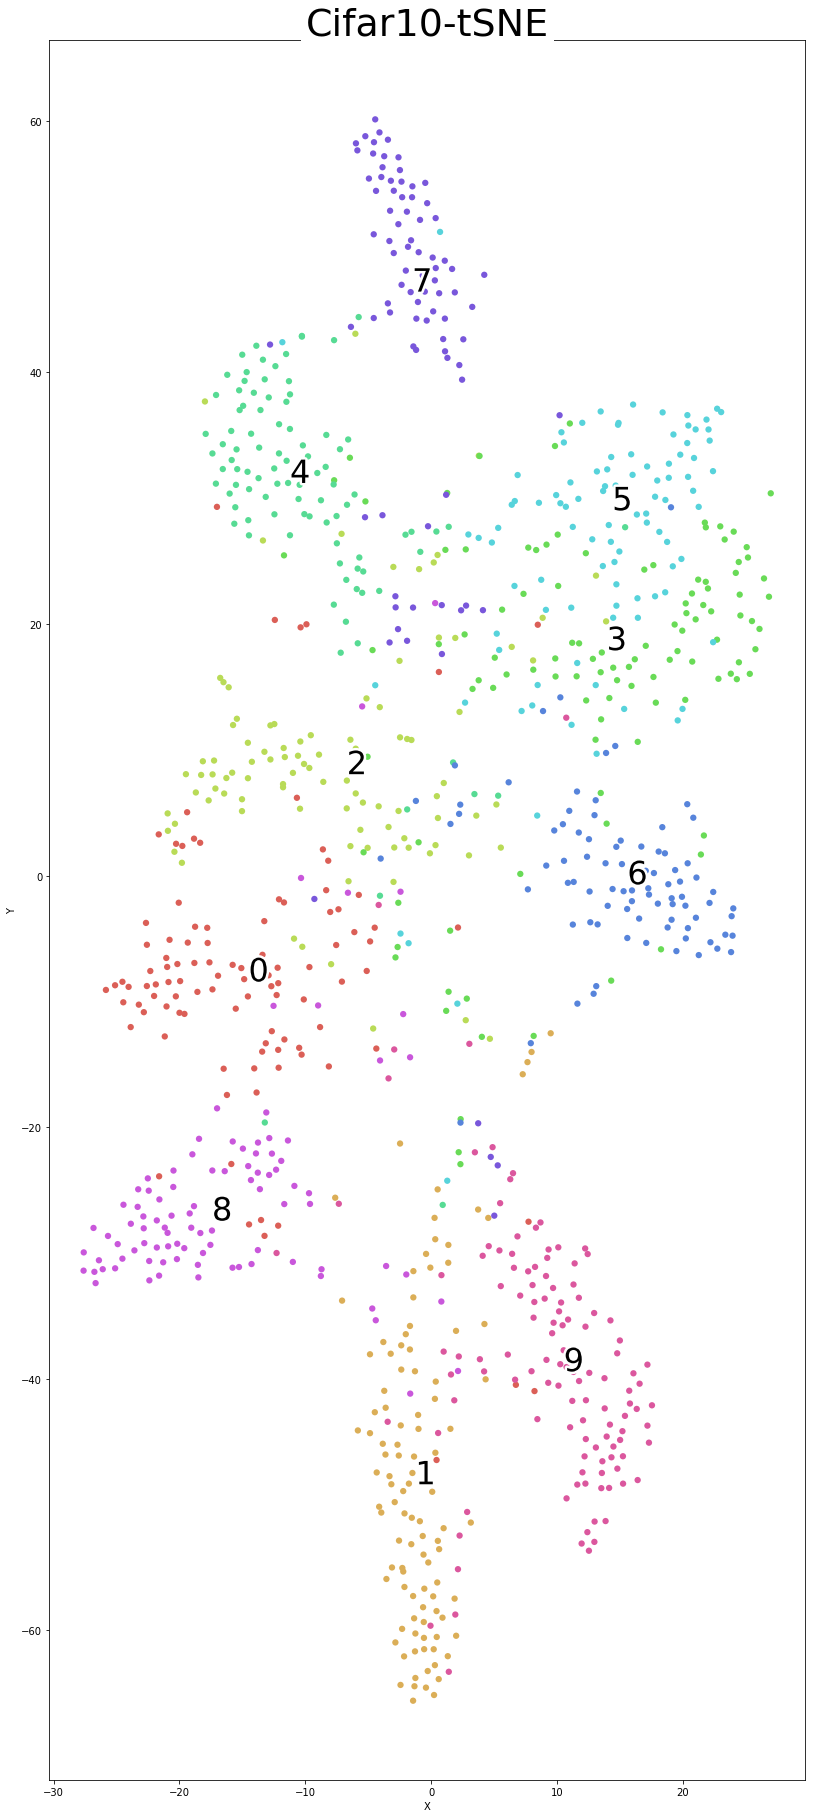

In [12]:
# 网络输出 测试集
X_test = np.load('Results/ZFNet_test_output.npy').astype(np.float64)
Y_test = np.load('Results/ZFNet_test_target.npy')
print('target shape: ', X_test.shape)
print('output shape: ', Y_test.shape)

# X=X.reshape(X.shape[0],-1)
# print(X.shape)
# print(type(Y))
X_test=X_test[0:1000,:]
Y_test=Y_test[0:1000,:]
# print('target shape: ', X.shape)
# print('output shape: ', Y.shape)
#     print(X)
#     print(Y)

X_test = np.vstack([X_test[(Y_test == i)[:, 0]] for i in range(num_label)])
Y_test = np.vstack([Y_test[(Y_test == i)[:, 0]] for i in range(num_label)])

tsne_output = TSNE(n_components=2, perplexity=30, n_iter=5000).fit_transform(X_test)
# print(tsne_output.shape)
# print(tsne_output)
plot2D(tsne_output, Y_test[:, 0],
       "Results/tSNE_ZFNet_test.png")

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np


class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, 11, 4, 2),  # 11+4*54<228=224+2*2
            nn.ReLU(),
            nn.MaxPool2d(3, 2),  # 3+2*26=55
            nn.Conv2d(96, 192, 5, 1, 2),  # 5+26=31=27+2*2
            nn.ReLU(),
            nn.MaxPool2d(3, 2),  # 3+2*12=27
            nn.Conv2d(192, 384, 3, 1, 1),  #3+12=15=13+1*2
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, 1, 1),  #3+12=15=13+1*2
            nn.ReLU(),
            # nn.Conv2d(256, 128, 3, 1, 1),  #3+12=15=13+1*2
            nn.Conv2d(256, 256, 3, 1, 1),  #3+12=15=13+1*2
            nn.ReLU(),
            # nn.MaxPool2d(3, 2),  # 3+2*5=13
            nn.MaxPool2d(5, 2, 1),  # 5+2*5=13+1*2
        )
        # self.features = nn.Sequential(
        #     nn.Conv2d(3, 64, 11, 4, 2),  # 11+4*54<228=224+2*2
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, 2),  # 3+2*26=55
        #     nn.Conv2d(64, 128, 5, 1, 2),  # 5+26=31=27+2*2
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, 2),  # 3+2*12=27
        #     nn.Conv2d(128, 256, 3, 1, 1),  #3+12=15=13+1*2
        #     nn.ReLU(),
        #     nn.Conv2d(256, 512, 3, 1, 1),  #3+12=15=13+1*2
        #     nn.ReLU(),
        #     nn.Conv2d(512, 128, 3, 1, 1),  #3+12=15=13+1*2
        #     # nn.Conv2d(256, 256, 3, 1, 1),  #3+12=15=13+1*2
        #     nn.ReLU(),
        #     nn.MaxPool2d(3, 2),  # 3+2*5=13
        #     # nn.MaxPool2d(5, 2, 1),  # 5+2*5=13+1*2
        # )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            # nn.Linear(128 * 6 * 6, 4096),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            # nn.Linear(4096, 4096),  # 1024
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(1024, 10))
        # nn.Linear(4096, 10))

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x.view(-1, 256 * 6 * 6))
        # x = self.classifier(x.view(-1, 128 * 6 * 6))
        return x


transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.465, 0.406], [0.229, 0.224, 0.225]),
])

train_data = dset.CIFAR10(root='cifar-10-batches-py',
                          train=True,
                          transform=transform,
                          download=False)
test_data = dset.CIFAR10(root='cifar-10-batches-py',
                         train=False,
                         transform=transform,
                         download=False)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=16,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=16,
                                          shuffle=True)



In [64]:
print(train_data.data.shape)
print(train_data[0][1])
print(train_data[0][0].shape)
print(train_data[0][0][0].shape)
print(train_data[0][0][1].shape)

print(train_data.data[49999].shape)

# print(type(train_data.labels))

(50000, 32, 32, 3)
6
torch.Size([3, 224, 224])
torch.Size([224, 224])
torch.Size([224, 224])
(32, 32, 3)


In [60]:
import pickle 
def load_file(filename): 
    with open(filename, 'rb') as fo: 
        data = pickle.load(fo, encoding='latin1') 
        return data
data = load_file('cifar-10-batches-py/test_batch')
print(data.keys())
print(type(data['filenames']))
print(data['data'].shape)

dict_keys(['batch_label', 'labels', 'data', 'filenames'])
<class 'list'>
(10000, 3072)


In [ ]:
train_len = len(train_data)
test_len = len(test_data)
print("AlexNet")
print(train_len, test_len)

if __name__ == '__main__':

    model = AlexNet()
    # model = model.cuda()
    optimzer = optim.SGD(model.parameters(), lr=0.01)

    print("batch_b16 pool5 nn.Linear(256 * 6 * 6, 4096) 128改256")
    for epoch in range(10):
        total_loss = 0
        train_correct = 0
        test_correct = 0
        cnt = 0
        for batch in train_loader:
            # cnt += len(data)
            # print("processing: %d/%d" % (cnt, len(train_loader.dataset)))
            images, labels = batch
            outs = model(images)
            loss = F.cross_entropy(outs, labels)
            # outs = model(images.cuda())
            # loss = F.cross_entropy(outs, labels.cuda())
            total_loss += loss.item()
            optimzer.zero_grad()
            loss.backward()
            optimzer.step()
            # train_correct += outs.argmax(dim=1).eq(labels.cuda()).sum().item()
            train_correct += outs.argmax(dim=1).eq(labels).sum().item()

        for batch in test_loader:
            images, labels = batch
            out = model(images)
            test_correct += out.argmax(dim=1).eq(labels).sum().item()
            # out = model(images.cuda())
            # test_correct = out.argmax(dim=1).eq(labels.cuda()).sum().item()
        train_correct = train_correct / train_len
        test_correct = test_correct / test_len
        print(epoch, ' -- total_loss:', total_loss, '  train_correct:',
              train_correct, '  test_correct:', test_correct)

    out_output = []
    out_target = []
    out_data = []
    # cnt=0
    # print("save final train output")
    for batch in train_loader:
        # cnt += len(data)
        # print("processing: %d/%d" % (cnt, len(train_loader.dataset)))
        images, labels = batch
        outs = model(images)

        output_np = outs.data.numpy()
        target_np = labels.data.numpy()
        data_np = images.data.numpy()
        out_output.append(output_np)
        out_target.append(target_np[:, np.newaxis])  #(10,)变(10,1)
        out_data.append(np.squeeze(data_np))

    output_array = np.concatenate(out_output, axis=0)
    target_array = np.concatenate(out_target, axis=0)
    data_array = np.concatenate(out_data, axis=0)
    # 不允许序列化
    np.save('out/AlexNet_b16_p5_256_output.npy',
            output_array,
            allow_pickle=False)
    np.save('out/AlexNet_b16_p5_256_target.npy',
            target_array,
            allow_pickle=False)
    # np.save('out/AlexNet_b8_data.npy', data_array, allow_pickle=False)

    out_output = []
    out_target = []
    out_data = []
    # cnt=0
    # print("save final test output")
    for batch in test_loader:
        # cnt += len(data)
        # print("processing: %d/%d" % (cnt, len(train_loader.dataset)))
        images, labels = batch
        outs = model(images)

        output_np = outs.data.numpy()
        target_np = labels.data.numpy()
        data_np = images.data.numpy()
        out_output.append(output_np)
        out_target.append(target_np[:, np.newaxis])  #(10,)变(10,1)
        out_data.append(np.squeeze(data_np))

    output_array = np.concatenate(out_output, axis=0)
    target_array = np.concatenate(out_target, axis=0)
    data_array = np.concatenate(out_data, axis=0)
    # 不允许序列化
    np.save('out/AlexNet_b16_p5_256_test_output.npy',
            output_array,
            allow_pickle=False)
    np.save('out/AlexNet_b16_p5_256_test_target.npy',
            target_array,
            allow_pickle=False)
    # np.save('out/AlexNet_b8_test_data.npy', data_array, allow_pickle=False)